In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Setup base directory for loading files

In [9]:
username= "wbeebe"
basedir = f"/astro/users/{username}/data/"

In [10]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.adapt(minimum=1, maximum=40) 

ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39088 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39088/status,
Dashboard: http://127.0.0.1:39088/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41994,Workers: 8
Dashboard: http://127.0.0.1:39088/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:36312,Total threads: 8
Dashboard: http://127.0.0.1:46687/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:37400,


In [11]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=True)

/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


2023-11-17 17:36:52,013 - distributed.core - INFO - Connection to tcp://127.0.0.1:41994 has been closed.
2023-11-17 17:36:52,013 - distributed.core - INFO - Connection to tcp://127.0.0.1:41994 has been closed.
2023-11-17 17:36:52,018 - distributed.core - INFO - Connection to tcp://127.0.0.1:41994 has been closed.
2023-11-17 17:36:52,063 - distributed.core - INFO - Connection to tcp://127.0.0.1:41994 has been closed.
2023-11-17 17:36:52,106 - distributed.core - INFO - Connection to tcp://127.0.0.1:41994 has been closed.
2023-11-17 17:36:52,469 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36313'.
2023-11-17 17:36:52,470 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:36313'. Shutting down.
2023-11-17 17:36:55,305 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2023-11-17 17:36:56,105 - distributed.core - INFO - Connection to tcp://127.0.0.1:41994 ha

In [12]:
"""
0. Negative log-likelihood of the Gaussian Process model
1. log_drw_scale = theta[0]
2. log_drw_amp = theta[1]
3. log_per_scale = theta[2]
4. log_per_amp = theta[3]
"""

res_tsp_run_0 = pd.read_parquet(f"{basedir}/res_tsp_run_g_0.parquet", engine='pyarrow')
res_tsp_run_0_drw = pd.read_parquet(f"{basedir}/res_tsp_run_g_0_drw.parquet", engine='pyarrow')
# numpy version of the results
res_tsp_run_0_np = np.vstack(res_tsp_run_0.values)
# res_tsp_run_0_drw = pd.read_parquet('/astro/users/ncaplar/data/res_tsp_run_0_drw', engine='pyarrow')
# res_tsp_run_0_drw_np = np.vstack(res_tsp_run_0_drw.data.values)

In [19]:
name_str = b'023922.87-000119.6'

ts_computed = ens._source.compute().loc[name_str]
ts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']
ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']

ens._source.compute().loc[name_str]

ens.query("band_ztf_source == 'g'", table = 'source')
ts = ens._source.compute().loc[name_str]
t = ts['mjd_ztf_source'].values
sort_array = np.argsort(t)
t = t[sort_array]
y = ts['mag_ztf_source'].values[sort_array]
yerr = ts['magerr_ztf_source'].values[sort_array]

t_r = ts_computed_r['mjd_ztf_source'].values
y_r = ts_computed_r['mag_ztf_source'].values
yerr_r = ts_computed_r['magerr_ztf_source'].values

In [20]:
x = np.linspace(np.min(t) - 100, np.max(t) + 100, 2000)


JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
theta = res_tsp_run_0.loc[name_str][2:6].values
theta_drw = res_tsp_run_0_drw.loc[name_str][2:4].values

gp = JaxPeriodDrwFit_instance.build_gp(theta, t, y, yerr)
gp_drw = JaxPeriodDrwFit_instance.build_gp_drw(theta_drw, t, y, yerr)

cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance

cond_gp_drw = gp_drw.condition(y, x).gp
mu_drw, var_drw = cond_gp_drw.loc, cond_gp_drw.variance

mu_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.loc
var_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.variance

mu_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.loc
var_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.variance

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
# To optimize per one
#JaxPeriodDrwFit_instance.optimize_map(t, y, yerr, n_init = 10000)

In [21]:
res_tsp_run_0.loc[name_str]

min_neg_log_lh       -365.651734
neg_log_lh           -365.651734
log_drw_scale           3.094614
log_drw_amp            -1.198606
log_per_scale           2.978630
log_per_amp            -0.990403
init_log_drw_scale      0.780093
init_log_drw_amp        1.537832
init_log_per_scale      3.032145
init_log_per_amp       -1.003249
Name: b'023922.87-000119.6', dtype: float64

In [22]:
res_tsp_run_0_drw.loc[name_str]

min_neg_log_lh       -358.138073
neg_log_lh           -358.138073
log_drw_scale           2.749800
log_drw_amp            -0.935381
init_log_drw_scale      1.061696
init_log_drw_amp        1.040602
Name: b'023922.87-000119.6', dtype: float64

In [23]:
y_r

array([15.333357 , 15.3543625, 15.3414345, 15.362863 , 15.310662 ,
       15.353295 , 15.326784 , 15.34214  , 15.327756 , 15.334055 ,
       15.323298 , 15.227307 , 15.219785 , 15.194593 , 15.346358 ,
       15.322029 , 15.337196 , 15.329466 , 15.342628 , 15.3306875,
       15.333767 , 15.3591795, 15.325183 , 15.334174 , 16.046242 ,
       15.347813 , 15.326755 , 15.356225 , 15.338949 , 15.148717 ,
       15.356345 , 15.330853 , 15.33323  , 15.343572 , 15.252072 ,
       15.272019 , 15.256985 , 15.2994175, 15.296247 , 15.347743 ,
       15.339332 , 15.345977 , 15.3479395, 15.365444 , 15.3272505,
       15.350485 , 15.35237  , 15.35903  , 15.266431 , 15.154489 ,
       15.143495 , 15.138816 , 15.111903 , 15.137131 , 15.165132 ,
       15.14014  , 15.191744 , 15.171262 , 15.20639  , 15.165941 ,
       15.198682 , 15.20674  , 15.280022 , 15.325967 , 15.14047  ,
       15.133851 , 15.129656 , 15.113819 , 15.250019 , 15.2967   ,
       15.285687 , 15.2172985, 15.306698 , 15.178156 , 15.1932

/tmp/ipykernel_99139/1723399926.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
/tmp/ipykernel_99139/1723399926.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')


(15.031477889051933, 15.603023944226843)

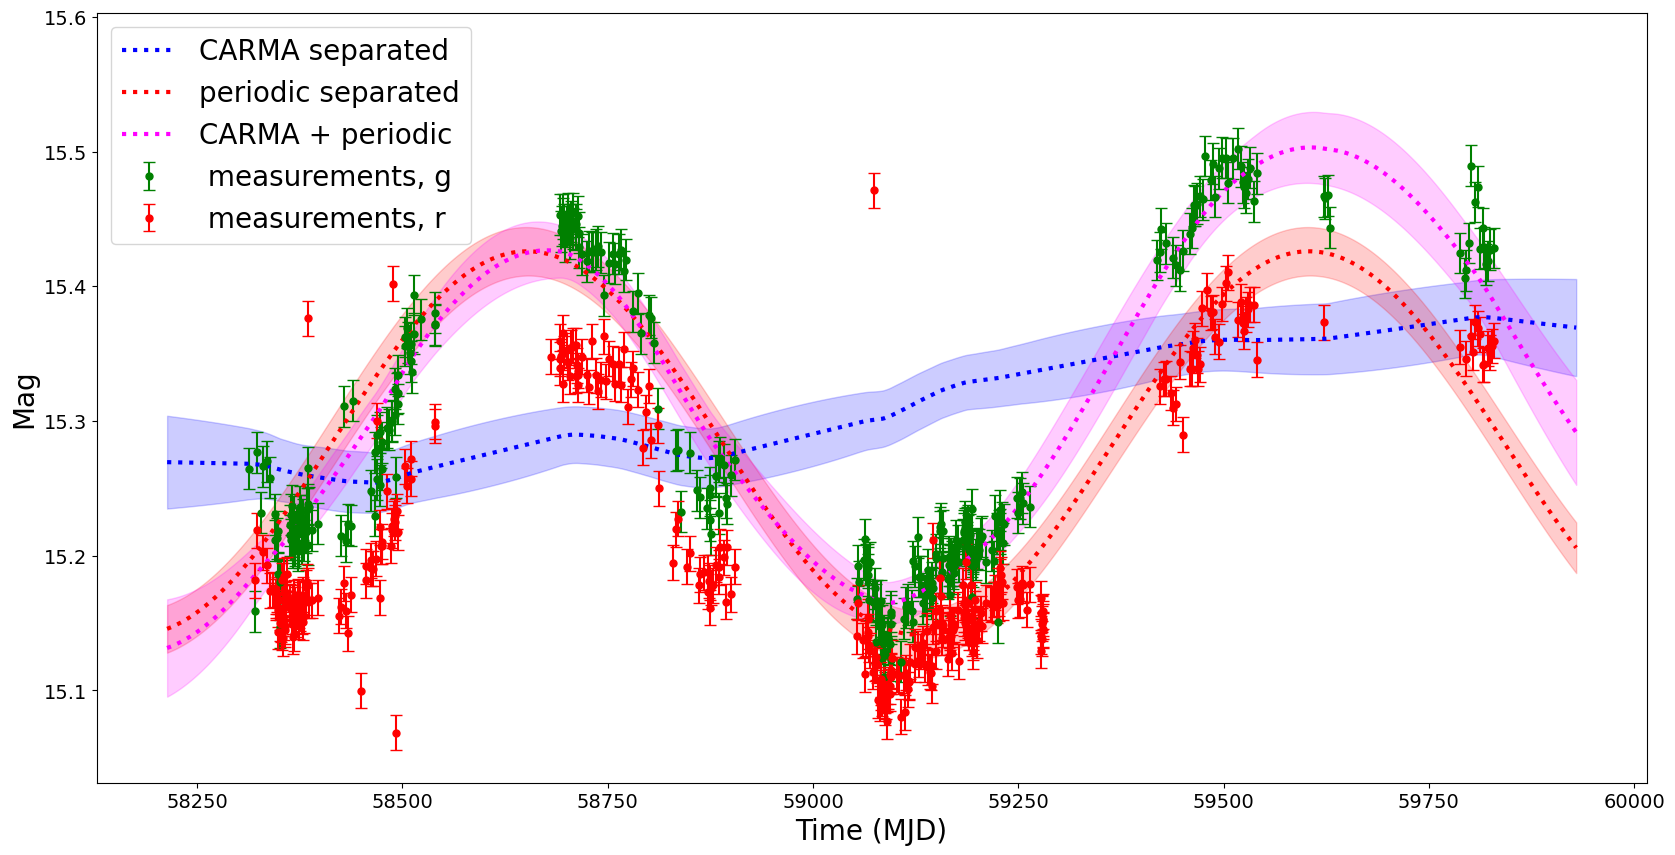

In [25]:
plt.figure(figsize=(20, 10))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')

plt.plot(x, mu_carma, color="blue", ls=':',lw=3, label = 'CARMA separated')
plt.plot(x, mu_periodic, color="red", ls=':', lw=3, label = 'periodic separated')

plt.fill_between(x, mu_carma + np.sqrt(var_carma),
                 mu_carma- np.sqrt(var_carma), color="blue", alpha=0.2)
plt.fill_between(x, mu_periodic + np.sqrt(var_periodic),
                 mu_periodic - np.sqrt(var_periodic), color="red", alpha=0.2)

plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="magenta", alpha=0.2)
plt.plot(x, mu, color="magenta", lw=3, ls=':', label = 'CARMA + periodic')

plt.xlabel("Time (MJD)", fontsize=20)
plt.ylabel("Mag", fontsize=20)
plt.legend(fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(np.min(mu)-0.1, np.max(mu)+0.1)

/tmp/ipykernel_99139/245866223.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
/tmp/ipykernel_99139/245866223.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')


Text(0.5, 1.0, 'Only DRW')

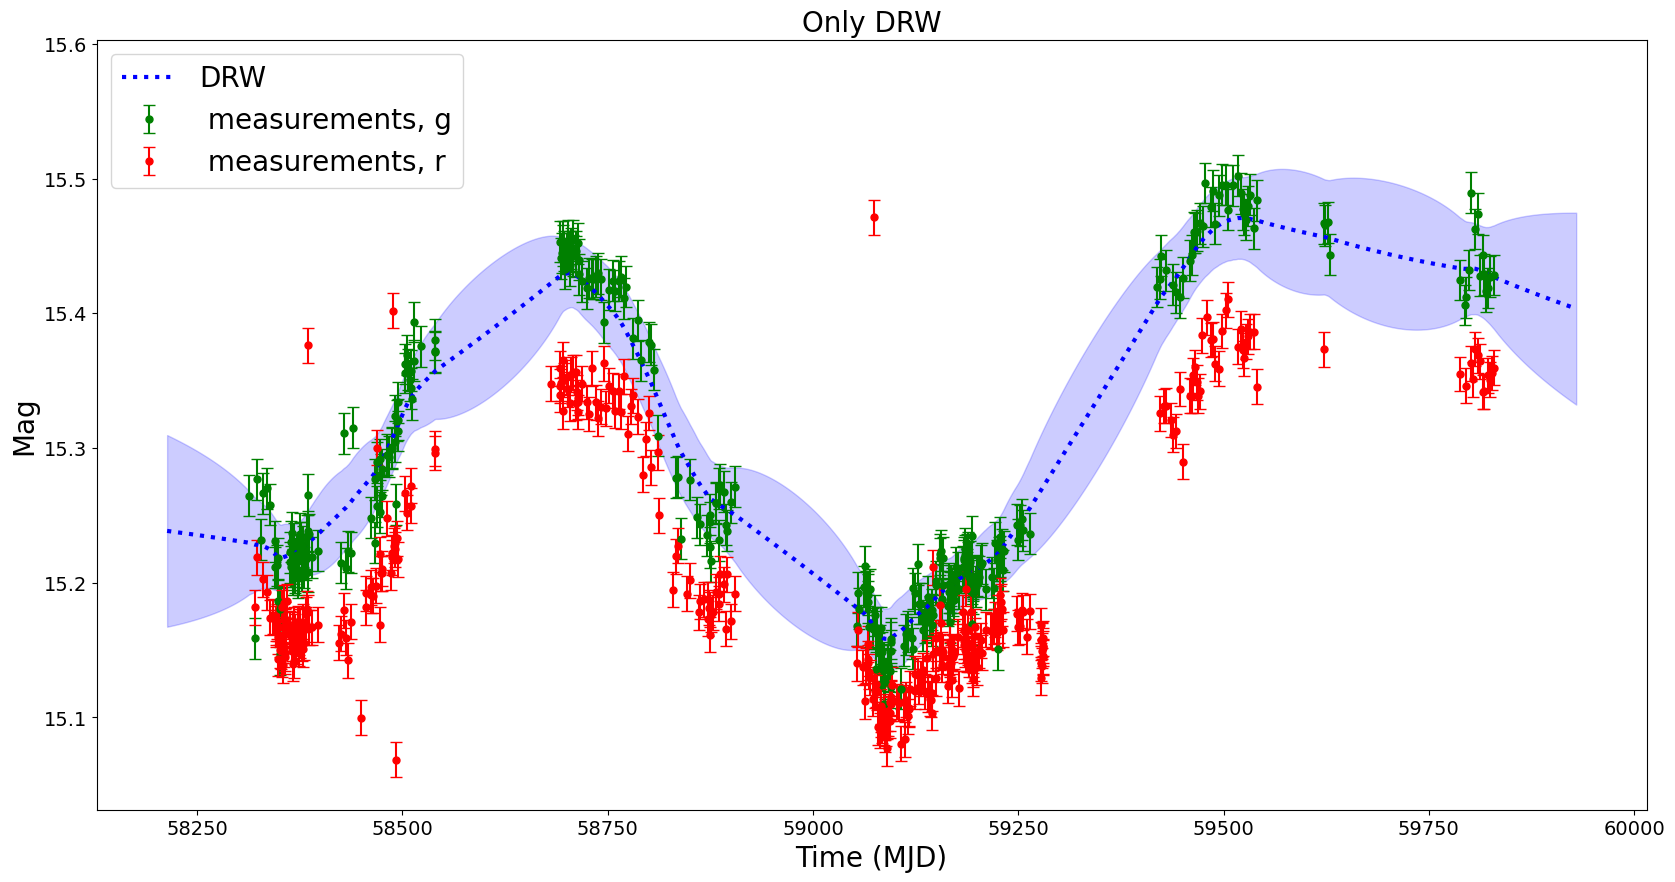

In [26]:
plt.figure(figsize=(20, 10))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')

plt.fill_between(x, mu_drw + np.sqrt(var_drw), mu_drw - np.sqrt(var_drw), color="blue", alpha=0.2)
plt.plot(x, mu_drw, color="blue", lw=3, ls=':', label = 'DRW')

plt.xlabel("Time (MJD)", fontsize=20)
plt.ylabel("Mag", fontsize=20)
plt.legend(fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(np.min(mu)-0.1, np.max(mu)+0.1)
plt.title('Only DRW',  fontsize=20)